In [1]:
import os
from functools import reduce

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from data_utils import get_gfp_peaks
import patchworklib as pw
import pingouin as pg
import seaborn as sns
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding

plt.style.use("papers")
plt.rcParams.update({"axes.facecolor": "white", "figure.facecolor": "white", "savefig.facecolor": "white"})
pw.overwrite_axisgrid()

COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]

FOLDER = "../../results/aggregated/"

DATA_TYPE = "real_data"
EOC = "EO"

<Figure size 72x72 with 0 Axes>

In [2]:
xr.open_dataarray(os.path.join(FOLDER, "segmentations.nc"))

<xarray.DataArray (data_type: 2, surrogate_type: 5, decomposition_type: 6, subject_id: 203, time: 62501)>
[761262180 values with dtype=float64]
Coordinates:
  * subject_id          (subject_id) object 'sub-010002' ... 'sub-010321'
  * time                (time) float64 0.0 0.004 0.008 ... 250.0 250.0 250.0
    no_states           int64 ...
  * decomposition_type  (decomposition_type) object 'AAHC' 'ICA' ... 'kmeans'
  * surrogate_type      (surrogate_type) object 'AAFT' 'FT' ... 'shuffle'
  * data_type           (data_type) object 'EC' 'EO'

In [3]:
segmentations = (
    xr.open_dataarray(os.path.join(FOLDER, "segmentations.nc"))
    .squeeze()
    .sel({"data_type": EOC, "surrogate_type": DATA_TYPE})
    .rename({"decomposition_type": "algorithm"})
)
segm_df = (
    segmentations.to_series()
    .reset_index()
    .replace({"hmm": "HMM", "kmeans": "mod. K-Means"})
    .rename(columns={0: "segmentation"})
)

In [4]:
segm_corrs = (
    segm_df.pivot(
        index=["subject_id", "time"], columns="algorithm", values="segmentation"
    )
    .groupby("subject_id")
    .corr("spearman")
    .unstack()
)

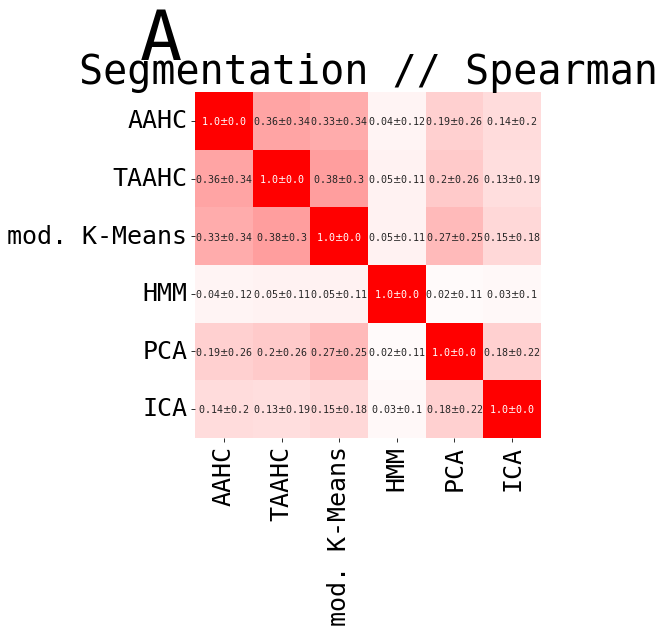

In [5]:
segm_mean = segm_corrs.mean().unstack().loc[COLUMNS_ORDER, COLUMNS_ORDER]
segm_mean.index.name = ""
segm_mean.columns.name = ""

segm_std = segm_corrs.std().unstack().loc[COLUMNS_ORDER, COLUMNS_ORDER]
segm_std.index.name = ""
segm_std.columns.name = ""

g1 = pw.Brick("ax0", figsize=(6, 6))
sns.heatmap(
    segm_mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=segm_mean.round(2).astype(str) + "$\pm$" + segm_std.round(2).astype(str),
    fmt="",
    ax=g1,
)
g1.set_title("Segmentation // Spearman")
g1.text(
    -0.1,
    1.15,
    "A",
    ha="center",
    va="center",
    transform=g1.transAxes,
    fontsize=70,
)
g1.savefig(quick=True)

In [6]:
stats = pd.read_csv(os.path.join(FOLDER, "stats.csv"))
stats

,subject_id,latent map,var_GFP,var_total,template_corr,coverage,occurrence,lifespan,transition->A,transition->B,...,stationarity L=1000 t,stationarity L=1000 p-val,stationarity L=2500 t,stationarity L=2500 p-val,stationarity L=5000 t,stationarity L=5000 p-val,Hurst exp.,Hurst intercept,data_type,surrogate_type
0,sub-010002_EC,A,0.360600,0.350981,0.205518,0.248844,15.871746,15.678427,0.744872,0.083199,...,1102.350956,1.843096e-17,446.454038,5.943305e-09,241.600057,1.915584e-08,0.581381,1.486639,EC,real_data
1,sub-010002_EC,B,0.360600,0.350981,0.433136,0.262348,15.415753,17.011160,0.078551,0.764957,...,1102.350956,1.843096e-17,446.454038,5.943305e-09,241.600057,1.915584e-08,0.581381,1.486639,EC,real_data
2,sub-010002_EC,C,0.360600,0.350981,0.770813,0.224988,15.255756,14.747771,0.094226,0.087968,...,1102.350956,1.843096e-17,446.454038,5.943305e-09,241.600057,1.915584e-08,0.581381,1.486639,EC,real_data
3,sub-010002_EC,D,0.360600,0.350981,0.741556,0.263820,15.923745,16.566692,0.082181,0.080180,...,1102.350956,1.843096e-17,446.454038,5.943305e-09,241.600057,1.915584e-08,0.581381,1.486639,EC,real_data
4,sub-010003_EC,A,0.376784,0.372304,0.284512,0.279612,12.139806,23.038893,0.826333,0.062772,...,1283.503674,8.774402e-33,614.377036,9.386306e-26,234.064277,1.095411e-07,0.592553,1.662613,EC,real_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48587,sub-010321_EO,D,0.507335,0.456225,0.723989,0.008800,0.714986,12.307692,0.000000,0.011364,...,364.077727,1.000000e+00,156.225627,9.999168e-01,83.229879,9.631526e-01,0.396028,3.619941,EO,shuffle
48588,sub-010319_EO,A,0.456208,0.394343,0.768623,0.050519,3.564929,14.171108,0.717736,0.160728,...,401.269670,1.000000e+00,168.850586,9.987441e-01,81.445340,9.734575e-01,0.424652,3.151197,EO,shuffle
48589,sub-010319_EO,B,0.456208,0.394343,0.670525,0.478730,14.349713,33.360279,0.016377,0.880097,...,401.269670,1.000000e+00,168.850586,9.987441e-01,81.445340,9.734575e-01,0.424652,3.151197,EO,shuffle
48590,sub-010319_EO,C,0.456208,0.394343,0.983411,0.054219,3.849923,14.083117,0.000000,0.154924,...,401.269670,1.000000e+00,168.850586,9.987441e-01,81.445340,9.734575e-01,0.424652,3.151197,EO,shuffle


In [7]:
stats = pd.read_csv(os.path.join(FOLDER, "stats.csv"))
stats = stats[(stats["surrogate_type"] == DATA_TYPE) & (stats["data_type"] == EOC)]
stats = stats.rename(columns={"decomposition_type": "algorithm"}).replace(
    {"hmm": "HMM", "kmeans": "mod. K-Means"}
)
stats = stats.sort_values(by="algorithm")

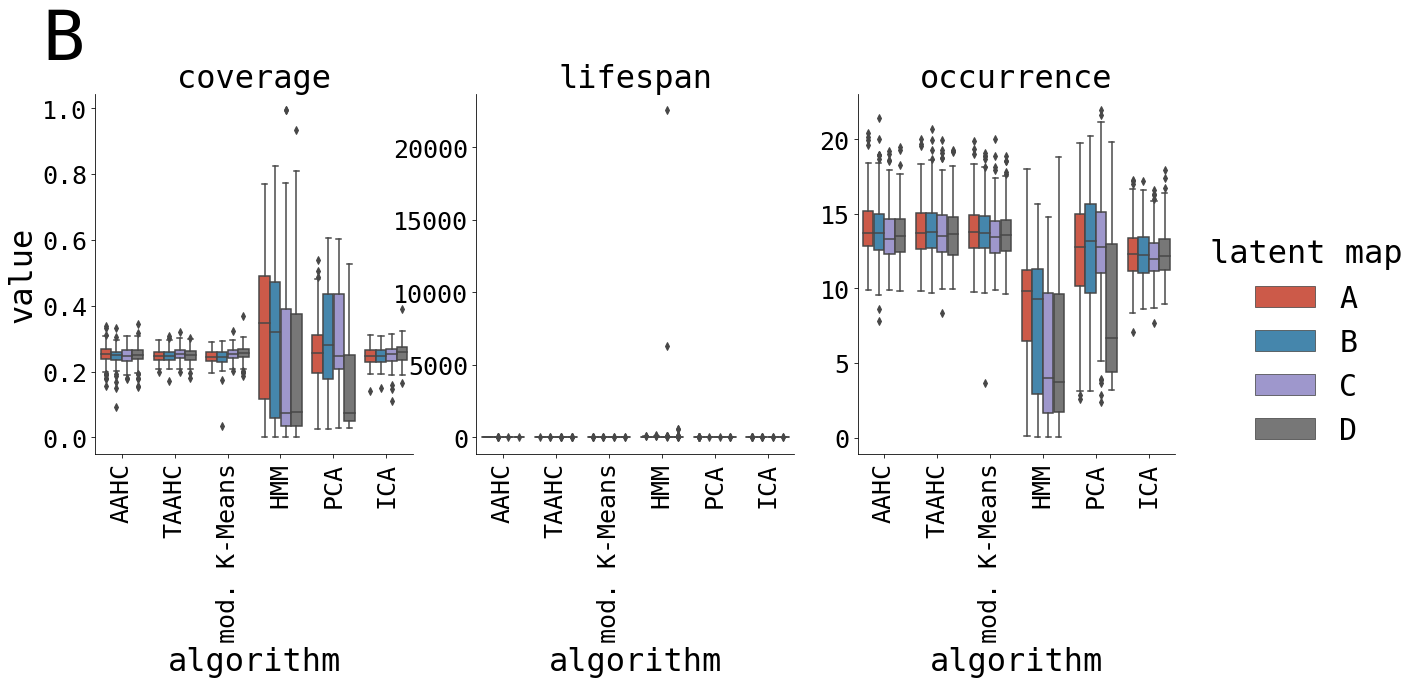

In [8]:
stats = (
    stats.rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
)
stats_melt = stats.melt(
    id_vars=["algorithm", "latent map"],
    value_vars=["coverage", "lifespan", "occurrence"],
)
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    hue="latent map",
    hue_order=["A", "B", "C", "D"],
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0][0].text(
    -0.1,
    1.15,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)

g2 = pw.load_seaborngrid(g)
g2.savefig(quick=True)

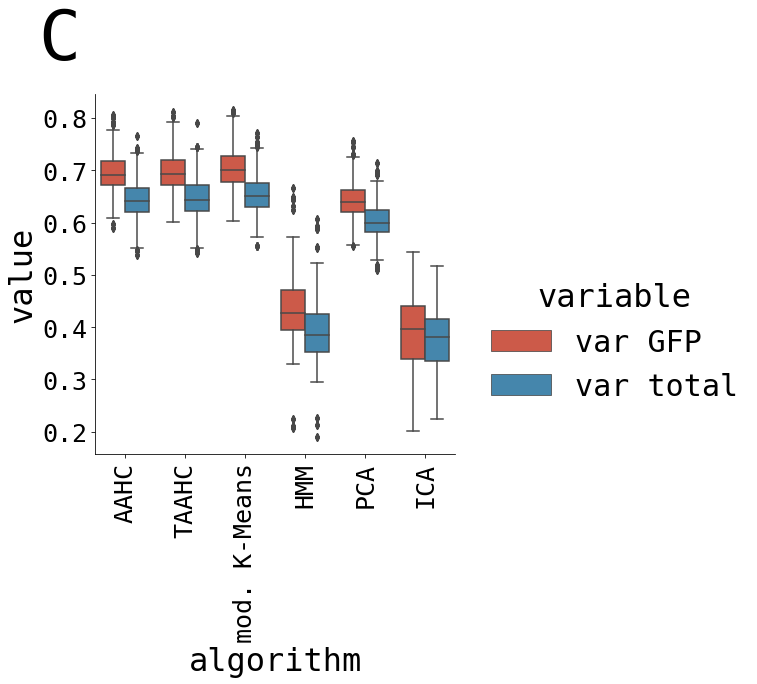

In [9]:
g = sns.catplot(
    data=stats.melt(id_vars="algorithm", value_vars=["var GFP", "var total"]),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)
g.axes[0][0].text(
    -0.1,
    1.15,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)

g3 = pw.load_seaborngrid(g)
g3.savefig(quick=True)

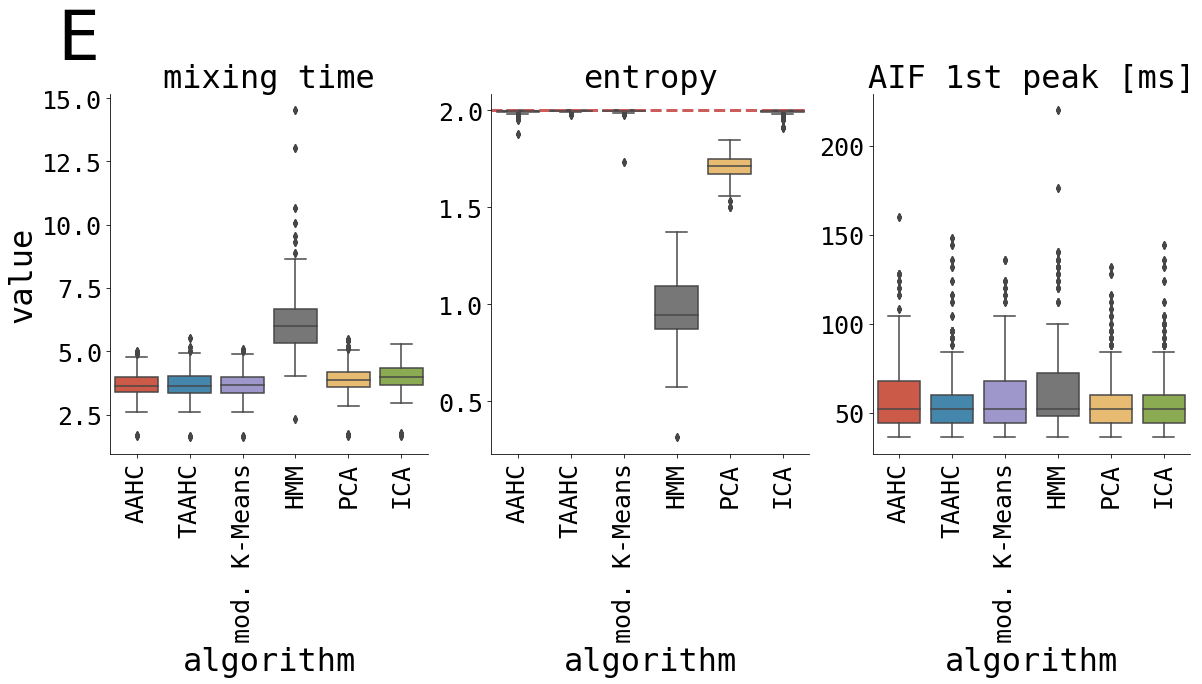

In [10]:
dynstats_melt = (
    stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["mixing time", "entropy", "AIF 1st peak [ms]"],
    )
)
g = sns.catplot(
    data=dynstats_melt,
    x="algorithm",
    y="value",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0, 1].axhline(
    stats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "E",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g4 = pw.load_seaborngrid(g)
g4.savefig(quick=True)

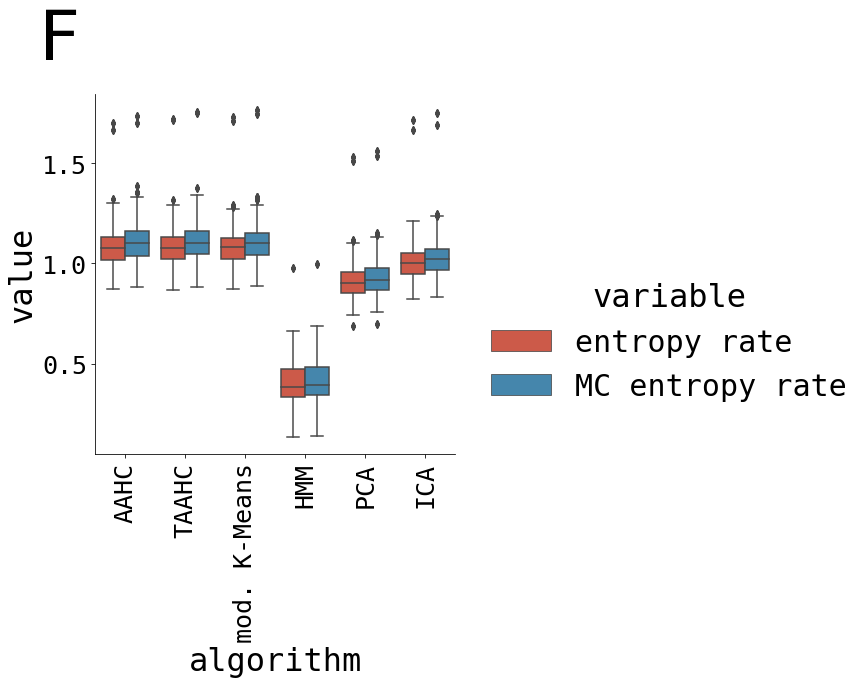

In [11]:
g = sns.catplot(
    data=stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["entropy rate", "MC entropy rate"],
    ),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)
g.axes[0][0].text(
    -0.1,
    1.15,
    "F",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)

g5 = pw.load_seaborngrid(g)
g5.savefig(quick=True)

In [12]:
subj_topo = (
    xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))
    .squeeze()
    .sel({"data_type": EOC, "surrogate_type": DATA_TYPE})
    .rename({"decomposition_type": "algorithm"})
)
rename_algs = {
    "AAHC": "AAHC",
    "TAAHC": "TAAHC",
    "ICA": "ICA",
    "PCA": "PCA",
    "hmm": "HMM",
    "kmeans": "mod. K-Means",
}
subj_topo["algorithm"] = [
    rename_algs[str(alg.values)] for alg in subj_topo["algorithm"]
]
# subj_topo = subj_topo.stack(all=("data_type", "surrogate_type", "subject_id"))

In [13]:
subj_topo

<xarray.DataArray (algorithm: 6, subject_id: 203, latent map: 4, channels: 61)>
[297192 values with dtype=float64]
Coordinates:
  * subject_id      (subject_id) object 'sub-010002' ... 'sub-010321'
  * latent map      (latent map) object 'A' 'B' 'C' 'D'
  * channels        (channels) int64 0 1 2 3 4 5 6 7 ... 53 54 55 56 57 58 59 60
    no_states       int64 ...
  * algorithm       (algorithm) <U12 'AAHC' 'ICA' 'PCA' ... 'HMM' 'mod. K-Means'
    surrogate_type  <U9 'real_data'
    data_type       <U2 'EO'

In [14]:
all_corrs = []
for alg1 in subj_topo["algorithm"]:
    for alg2 in subj_topo["algorithm"]:
        for map1 in subj_topo["latent map"]:
            for map2 in subj_topo["latent map"]:
                corrs = (
                    xr.corr(
                        subj_topo.sel({"algorithm": alg1, "latent map": map1}),
                        subj_topo.sel({"algorithm": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = np.abs(xr.combine_by_coords(all_corrs))

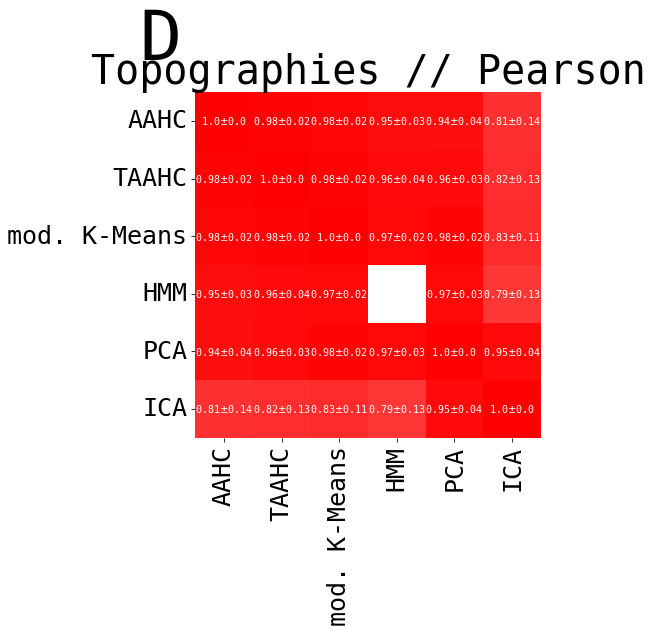

In [15]:
mean = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .mean("subject_id")
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
mean.index.name = ""
mean.columns = mean.columns.get_level_values(1)
mean.columns.name = ""
mean = mean.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

std = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .std("subject_id", ddof=1)
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
std.index.name = ""
std.columns = std.columns.get_level_values(1)
std.columns.name = ""
std = std.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

g6 = pw.Brick("ax2", figsize=(6, 6))
sns.heatmap(
    mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=mean.round(2).astype(str) + "$\pm$" + std.round(2).astype(str),
    fmt="",
    ax=g6,
)
g6.text(
    -0.1,
    1.15,
    "D",
    ha="center",
    va="center",
    transform=g6.transAxes,
    fontsize=70,
)
g6.set_title("Topographies // Pearson")
g6.savefig(quick=True)

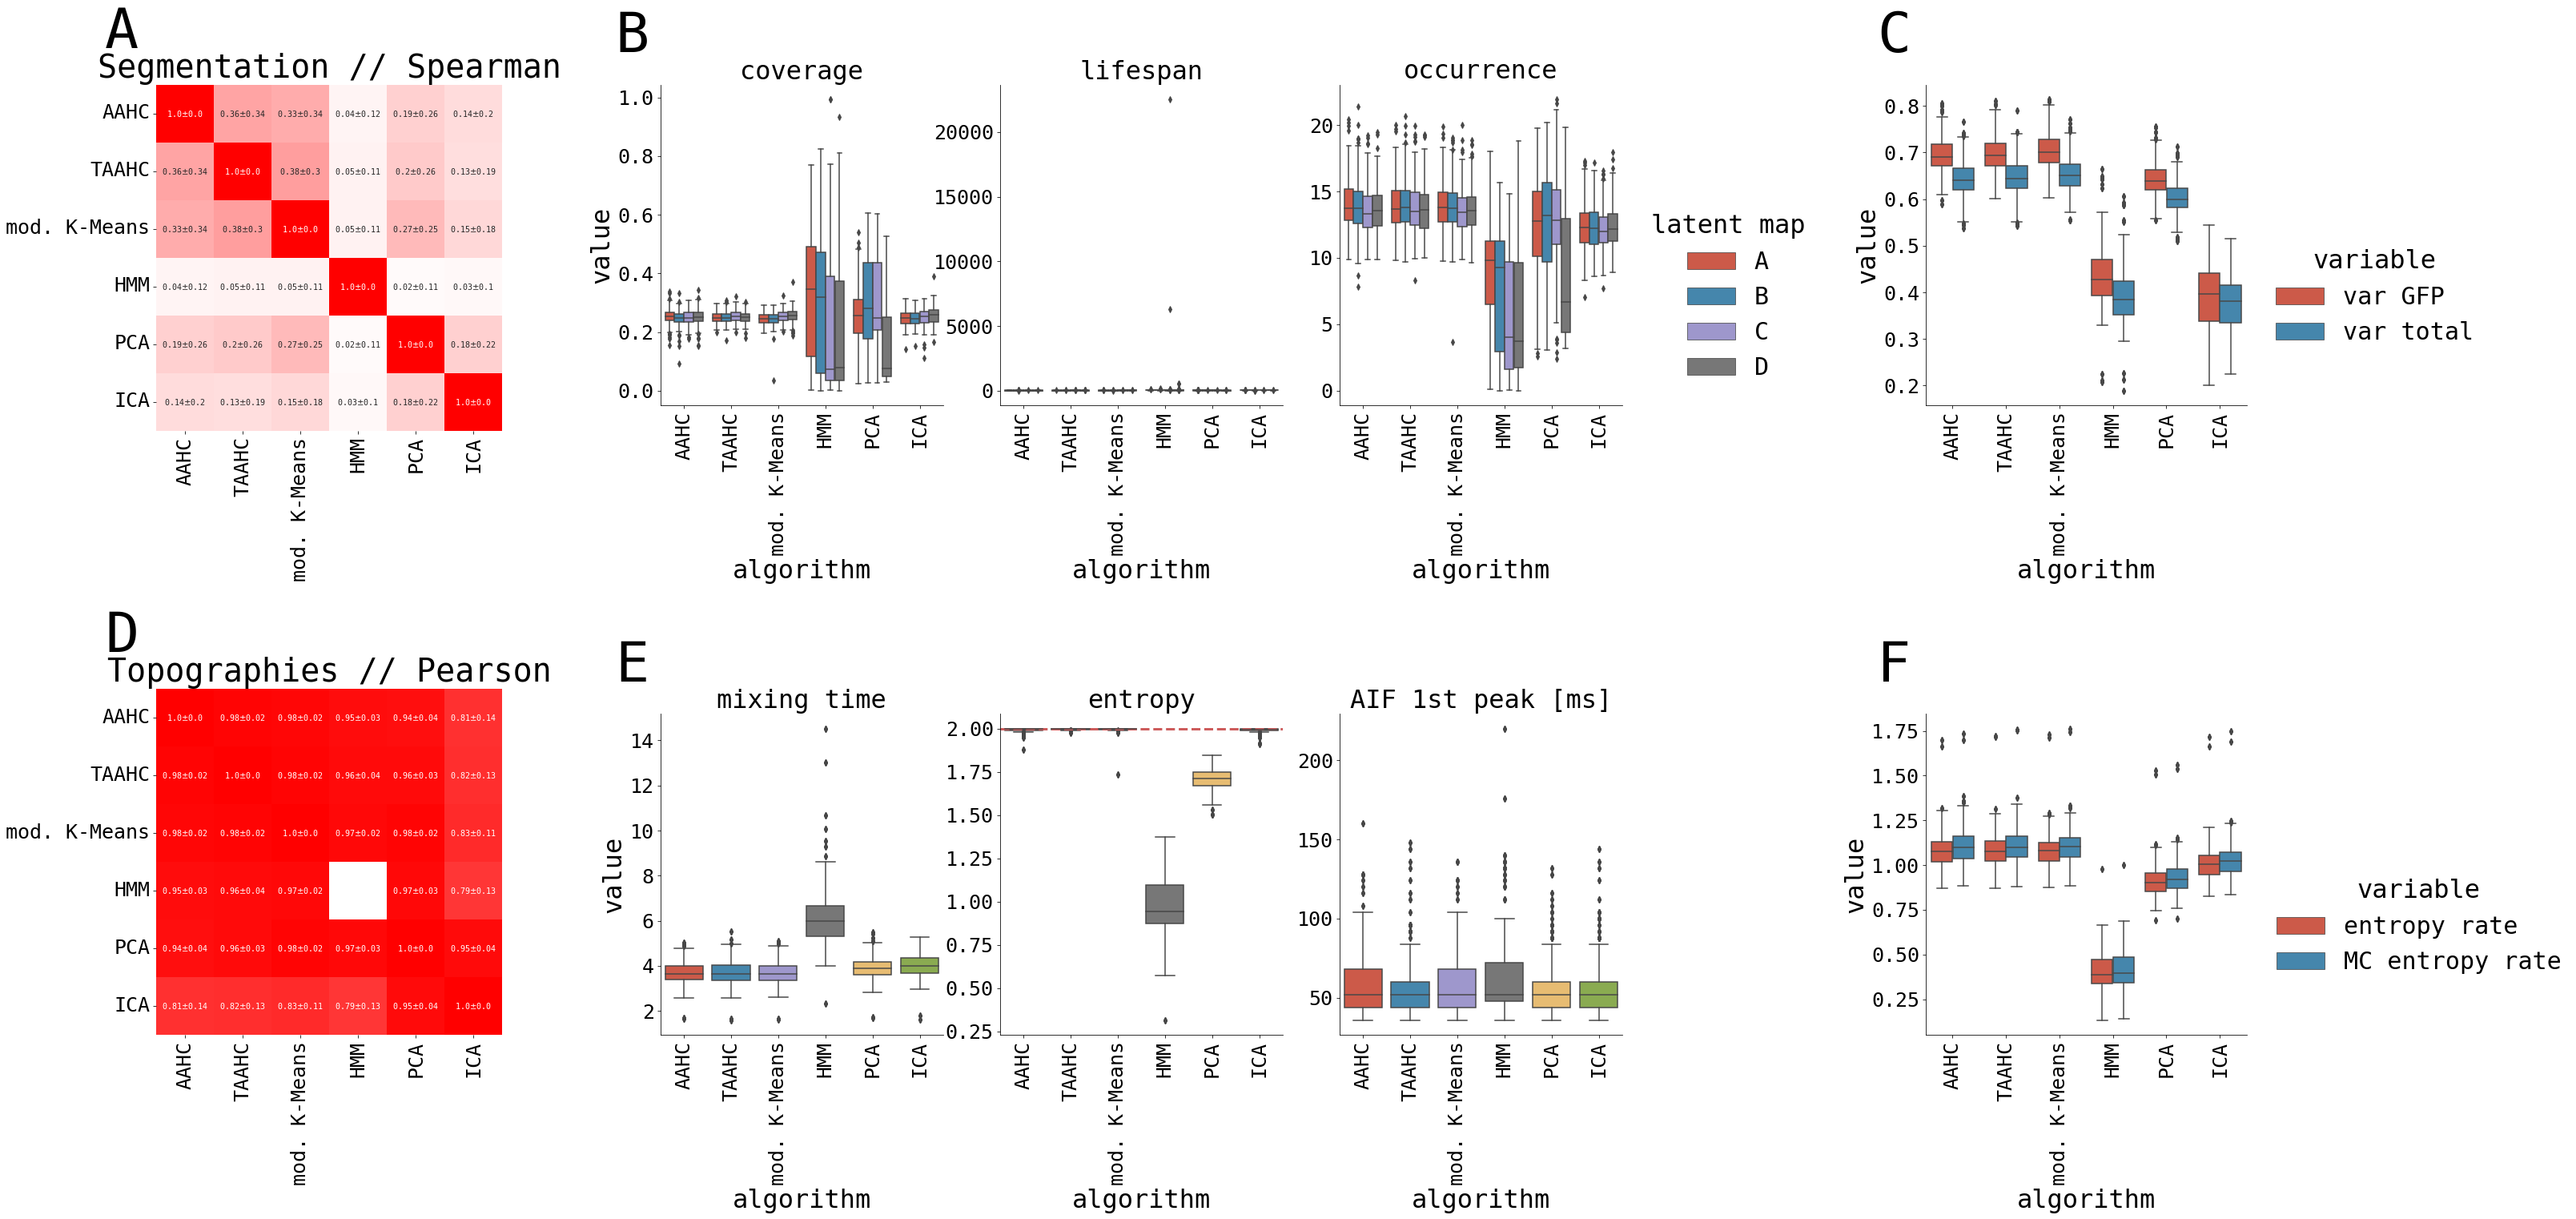

In [16]:
((g1 / g6) | (g2 / g4) | (g3 / g5)).savefig(
    fname=f"LEMON_{DATA_TYPE}_{EOC}_stats.pdf", transparent=True
)

In [17]:
rename_algs = {
    "AAHC": "AAHC",
    "TAAHC": "TAAHC",
    "ICA": "ICA",
    "PCA": "PCA",
    "hmm": "HMM",
    "kmeans": "mod. K-Means",
}
segmentations["algorithm"] = [
    rename_algs[str(alg.values)] for alg in segmentations["algorithm"]
]
segmentations

<xarray.DataArray (algorithm: 6, subject_id: 203, time: 62501)>
array([[[ 1.,  2., ..., nan, nan],
        [ 2.,  3., ..., nan, nan],
        ...,
        [ 1.,  2., ..., nan, nan],
        [ 3.,  0., ..., nan, nan]],

       [[ 0.,  1., ...,  0.,  3.],
        [ 3.,  3., ...,  1.,  3.],
        ...,
        [ 1.,  2., ...,  3.,  3.],
        [ 1.,  1., ...,  0.,  0.]],

       ...,

       [[ 0.,  0., ..., nan, nan],
        [ 3.,  0., ..., nan, nan],
        ...,
        [ 1.,  1., ..., nan, nan],
        [ 0.,  0., ..., nan, nan]],

       [[ 1.,  3., ...,  1.,  2.],
        [ 2.,  3., ...,  2.,  0.],
        ...,
        [ 2.,  2., ...,  2.,  3.],
        [ 2.,  1., ...,  0.,  0.]]])
Coordinates:
  * subject_id      (subject_id) object 'sub-010002' ... 'sub-010321'
  * time            (time) float64 0.0 0.004 0.008 0.012 ... 250.0 250.0 250.0
    no_states       int64 ...
  * algorithm       (algorithm) <U12 'AAHC' 'ICA' 'PCA' ... 'HMM' 'mod. K-Means'
    surrogate_type  <U9 'real_data'
    data_type       <U2 'EO'

In [18]:
RND_SUBJECT = f"sub-010005_{EOC}"
subj_data = mne.io.read_raw_eeglab(f"../../data/test_data_LEMON/{RND_SUBJECT}.set", preload=True)
subj_data.crop(tmax=250.0)
subj_data = pd.DataFrame(subj_data.get_data().T, columns=subj_data.info["ch_names"], index=segmentations.time)
peaks, _ = get_gfp_peaks(
    subj_data.values.T,
    min_peak_dist=2,
    smoothing=None,
    smoothing_window=100,
)
subj_data["GFP"] = False
subj_data.iloc[peaks, -1] = True
subj_data

Reading /Users/nikola/work-brain/eeg_microstate_and_latent_space/notebooks/paper1_figs/../../data/test_data_LEMON/sub-010005_EO.fdt
Reading 0 ... 119821  =      0.000 ...   479.284 secs...


,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P5,P1,P2,P6,PO7,PO3,POz,PO4,PO8,GFP
0.000,5.218773e-06,0.000005,0.000007,3.014510e-06,-1.063863e-06,3.461579e-08,1.013806e-05,6.612749e-06,2.439962e-06,-1.443194e-06,...,0.000011,0.000010,0.000010,0.000014,0.000013,0.000011,0.000011,0.000010,0.000017,False
0.004,5.635639e-06,0.000006,0.000008,1.702521e-06,-5.716465e-07,1.698660e-06,1.209566e-05,5.995735e-06,1.126152e-06,-5.927372e-07,...,0.000014,0.000012,0.000012,0.000017,0.000017,0.000015,0.000013,0.000013,0.000020,True
0.008,4.268695e-06,0.000005,0.000006,-1.008042e-07,-6.992306e-07,2.186101e-06,1.127792e-05,3.411132e-06,-3.623928e-07,2.458024e-07,...,0.000014,0.000011,0.000011,0.000017,0.000017,0.000014,0.000013,0.000012,0.000019,False
0.012,2.342911e-06,0.000003,0.000004,-1.509362e-06,-1.168453e-06,1.963986e-06,9.029571e-06,4.182730e-07,-1.603702e-06,1.031032e-06,...,0.000009,0.000008,0.000008,0.000013,0.000013,0.000010,0.000010,0.000010,0.000016,False
0.016,1.420878e-06,0.000002,0.000002,-1.743021e-06,-1.481822e-06,1.567123e-06,6.454685e-06,-1.137847e-06,-2.403624e-06,1.668371e-06,...,0.000003,0.000003,0.000004,0.000008,0.000006,0.000005,0.000004,0.000005,0.000011,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249.984,4.490900e-07,-0.000004,0.000010,5.218317e-06,-2.158011e-06,-3.207634e-07,4.341924e-06,1.187525e-05,3.711965e-06,-9.209448e-07,...,0.000034,0.000030,0.000027,0.000036,0.000035,0.000039,0.000037,0.000037,0.000036,False
249.988,-6.352772e-07,-0.000005,0.000010,3.982509e-06,-2.708326e-06,-2.003773e-06,3.656296e-06,1.061634e-05,3.622573e-06,-1.853105e-06,...,0.000031,0.000026,0.000025,0.000033,0.000032,0.000036,0.000034,0.000035,0.000034,False
249.992,-2.344639e-06,-0.000006,0.000008,2.797683e-06,-3.313994e-06,-4.395071e-06,9.473261e-07,8.241551e-06,3.392034e-06,-3.325828e-06,...,0.000024,0.000019,0.000019,0.000028,0.000026,0.000029,0.000027,0.000029,0.000028,False
249.996,-3.892032e-06,-0.000008,0.000006,1.626623e-06,-3.752840e-06,-6.439527e-06,-2.126133e-06,5.430239e-06,3.109147e-06,-4.928484e-06,...,0.000017,0.000013,0.000011,0.000019,0.000018,0.000021,0.000018,0.000020,0.000020,False


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

segmentation_subject = segmentations.sel({"subject_id": RND_SUBJECT[:-3]}).isel({"time": subj_data["GFP"]})
# segmentation_subject.sel({"algorithm": "mod. K-Means"})
scaler = StandardScaler()
svm_data = subj_data[subj_data["GFP"]].drop("GFP", axis=1)
svm_data = pd.DataFrame(scaler.fit_transform(svm_data), index=svm_data.index, columns=svm_data.columns)
svm_data["K-Means"] = segmentation_subject.sel({"algorithm": "mod. K-Means"}).values
svm_data
svc = SVC(kernel="linear", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1])
svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape


((7284, 61),
 array([0., 1., 2., 3.]),
 array([1587, 1794, 1827, 2076], dtype=int32),
 (7284,))

In [20]:
svc = SVC(kernel="linear", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1])
print(svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape)

svc = SVC(kernel="rbf", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1])
print(svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape)

svc = SVC(kernel="poly", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1])
print(svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape)

svc = SVC(kernel="sigmoid", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1])
print(svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape)

(7284, 61) [0. 1. 2. 3.] [1587 1794 1827 2076] (7284,)
(3970, 61) [0. 1. 2. 3.] [ 889 1009  969 1103] (3970,)
(7243, 61) [0. 1. 2. 3.] [1585 1783 1817 2058] (7243,)
(6737, 61) [0. 1. 2. 3.] [1584 1663 1544 1946] (6737,)


In [21]:
svc = SVC(kernel="linear", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1].replace({1.0: 1., 2.0: 1., 3.0: 1.}))
svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape

# dimred = PCA(n_components=5)
# plot_d = dimred.fit_transform(svm_data.iloc[:, :-1])
# plot_d = pd.DataFrame(plot_d, index=svm_data.index, columns=[f"PC_{i}" for i in range(5)])

# g = sns.pairplot(plot_d)
# g20 = pw.load_seaborngrid(g)
# g20.savefig(quick=True)

((4026, 61), array([0., 1.]), array([1587, 2439], dtype=int32), (4026,))

In [22]:
# def get_pca(algo, n_comps=5):
#     pca = PCA(n_components=n_comps)
#     pca_data = subj_data[subj_data["GFP"]]
#     pcs = pca.fit_transform(pca_data.values)
#     pcs = pd.DataFrame(
#         pcs, columns=[f"PC {i}" for i in range(n_comps)], index=pca_data.index
#     )
#     pcs[algo] = segmentations.sel({"subject_id": RND_SUBJECT[:-3], "algorithm": algo, "time": subj_data[subj_data["GFP"]].index.values})

#     g = sns.PairGrid(pcs, vars=[f"PC {i}" for i in range(n_comps)], hue=algo)
#     g.map_diag(sns.histplot, bins=30, alpha=0.5)
#     g.map_offdiag(sns.scatterplot)
#     g.axes[0, 0].set_title(algo)

#     return g

In [23]:
# for comp in range(2, 6):
#     g10 = pw.load_seaborngrid(get_pca("AAHC", n_comps=comp))
#     g11 = pw.load_seaborngrid(get_pca("TAAHC", n_comps=comp))
#     g12 = pw.load_seaborngrid(get_pca("mod. K-Means", n_comps=comp))
#     g13 = pw.load_seaborngrid(get_pca("HMM", n_comps=comp))
#     g14 = pw.load_seaborngrid(get_pca("PCA", n_comps=comp))
#     g15 = pw.load_seaborngrid(get_pca("ICA", n_comps=comp))
#     ((g10 | g11 | g12) / (g13 | g14 | g15)).savefig(
#         fname=f"LEMON_{EOC}_{RND_SUBJECT}_GFP_lowdim_{comp}.png"
#         # quick=True
#     )

In [24]:
# def get_pca(decomp, n_comps=2):
#     data = (
#         subj_topo.stack(samples=("subject_id", "latent map"))
#         .sel({"algorithm": decomp})
#         .where(
#             (
#                 subj_topo.stack(samples=("subject_id", "latent map")).sel(
#                     {"algorithm": decomp}
#                 )
#                 < subj_topo.stack(samples=("subject_id", "latent map"))
#                 .sel({"algorithm": decomp})
#                 .quantile(0.99)
#             )
#             & (
#                 subj_topo.stack(samples=("subject_id", "latent map")).sel(
#                     {"algorithm": decomp}
#                 )
#                 > subj_topo.stack(samples=("subject_id", "latent map"))
#                 .sel({"algorithm": decomp})
#                 .quantile(0.01)
#             )
#         )
#         .dropna("samples")
#         .dropna("channels")
#     )
#     pca = PCA(n_components=n_comps)
#     pcs = pca.fit_transform(data.values.T)
#     low_dim = pd.DataFrame(pcs, columns=[f"PC {i}" for i in range(n_comps)])
#     low_dim["map"] = data["latent map"]
#     g = sns.PairGrid(low_dim, vars=[f"PC {i}" for i in range(n_comps)], hue="map")
#     g.map_diag(sns.histplot, bins=30, alpha=0.5)
#     g.map_offdiag(sns.scatterplot)
#     g.axes[0, 1].set_title(decomp)
#     return g


# def get_tsne(decomp, n_comps=2):
#     data = (
#         subj_topo.stack(samples=("subject_id", "latent map"))
#         .sel({"algorithm": decomp})
#         .where(
#             (
#                 subj_topo.stack(samples=("subject_id", "latent map")).sel(
#                     {"algorithm": decomp}
#                 )
#                 < subj_topo.stack(samples=("subject_id", "latent map"))
#                 .sel({"algorithm": decomp})
#                 .quantile(0.99)
#             )
#             & (
#                 subj_topo.stack(samples=("subject_id", "latent map")).sel(
#                     {"algorithm": decomp}
#                 )
#                 > subj_topo.stack(samples=("subject_id", "latent map"))
#                 .sel({"algorithm": decomp})
#                 .quantile(0.01)
#             )
#         )
#         .dropna("samples")
#         .dropna("channels")
#     )
#     tsne = TSNE(n_components=n_comps, init="pca", n_jobs=6, method="exact")
#     pcs = tsne.fit_transform(data.values.T)
#     low_dim = pd.DataFrame(pcs, columns=[f"t-SNE {i}" for i in range(n_comps)])
#     low_dim["map"] = data["latent map"]
#     g = sns.PairGrid(low_dim, vars=[f"t-SNE {i}" for i in range(n_comps)], hue="map")
#     g.map_diag(sns.histplot, bins=30, alpha=0.5)
#     g.map_offdiag(sns.scatterplot)
#     return g


# def get_mds(decomp, n_comps=2):
#     data = (
#         subj_topo.stack(samples=("subject_id", "latent map"))
#         .sel({"algorithm": decomp})
#         .where(
#             (
#                 subj_topo.stack(samples=("subject_id", "latent map")).sel(
#                     {"algorithm": decomp}
#                 )
#                 < subj_topo.stack(samples=("subject_id", "latent map"))
#                 .sel({"algorithm": decomp})
#                 .quantile(0.99)
#             )
#             & (
#                 subj_topo.stack(samples=("subject_id", "latent map")).sel(
#                     {"algorithm": decomp}
#                 )
#                 > subj_topo.stack(samples=("subject_id", "latent map"))
#                 .sel({"algorithm": decomp})
#                 .quantile(0.01)
#             )
#         )
#         .dropna("samples")
#         .dropna("channels")
#     )
#     mds = MDS(n_components=n_comps, n_jobs=6)
#     pcs = mds.fit_transform(data.values.T)
#     low_dim = pd.DataFrame(pcs, columns=[f"MDS {i}" for i in range(n_comps)])
#     low_dim["map"] = data["latent map"]
#     g = sns.PairGrid(low_dim, vars=[f"MDS {i}" for i in range(n_comps)], hue="map")
#     g.map_diag(sns.histplot, bins=30, alpha=0.5)
#     g.map_offdiag(sns.scatterplot)
#     return g


# def get_lle(decomp, n_comps=2):
#     data = (
#         subj_topo.stack(samples=("subject_id", "latent map"))
#         .sel({"algorithm": decomp})
#         .where(
#             (
#                 subj_topo.stack(samples=("subject_id", "latent map")).sel(
#                     {"algorithm": decomp}
#                 )
#                 < subj_topo.stack(samples=("subject_id", "latent map"))
#                 .sel({"algorithm": decomp})
#                 .quantile(0.99)
#             )
#             & (
#                 subj_topo.stack(samples=("subject_id", "latent map")).sel(
#                     {"algorithm": decomp}
#                 )
#                 > subj_topo.stack(samples=("subject_id", "latent map"))
#                 .sel({"algorithm": decomp})
#                 .quantile(0.01)
#             )
#         )
#         .dropna("samples")
#         .dropna("channels")
#     )
#     lle = LocallyLinearEmbedding(n_components=n_comps, n_neighbors=10, n_jobs=6)
#     pcs = lle.fit_transform(data.values.T)
#     low_dim = pd.DataFrame(pcs, columns=[f"LLE {i}" for i in range(n_comps)])
#     low_dim["map"] = data["latent map"]
#     g = sns.PairGrid(low_dim, vars=[f"LLE {i}" for i in range(n_comps)], hue="map")
#     g.map_diag(sns.histplot, bins=30, alpha=0.5)
#     g.map_offdiag(sns.scatterplot)
#     return g


# # maps["algorithm"] = ["AAHC", "HMM", "ICA", "PCA", "TAAHC", "mod. K-Means"]


# for comp in range(2, 5):
#     g = get_pca("AAHC", n_comps=comp)
#     g10 = pw.load_seaborngrid(g)
#     g11 = pw.load_seaborngrid(get_pca("TAAHC", n_comps=comp))
#     g12 = pw.load_seaborngrid(get_pca("mod. K-Means", n_comps=comp))
#     g13 = pw.load_seaborngrid(get_pca("HMM", n_comps=comp))
#     g14 = pw.load_seaborngrid(get_pca("PCA", n_comps=comp))
#     g15 = pw.load_seaborngrid(get_pca("ICA", n_comps=comp))

#     g20 = pw.load_seaborngrid(get_tsne("AAHC", n_comps=comp))
#     g21 = pw.load_seaborngrid(get_tsne("TAAHC", n_comps=comp))
#     g22 = pw.load_seaborngrid(get_tsne("mod. K-Means", n_comps=comp))
#     g23 = pw.load_seaborngrid(get_tsne("HMM", n_comps=comp))
#     g24 = pw.load_seaborngrid(get_tsne("PCA", n_comps=comp))
#     g25 = pw.load_seaborngrid(get_tsne("ICA", n_comps=comp))

#     g30 = pw.load_seaborngrid(get_mds("AAHC", n_comps=comp))
#     g31 = pw.load_seaborngrid(get_mds("TAAHC", n_comps=comp))
#     g32 = pw.load_seaborngrid(get_mds("mod. K-Means", n_comps=comp))
#     g33 = pw.load_seaborngrid(get_mds("HMM", n_comps=comp))
#     g34 = pw.load_seaborngrid(get_mds("PCA", n_comps=comp))
#     g35 = pw.load_seaborngrid(get_mds("ICA", n_comps=comp))

#     g40 = pw.load_seaborngrid(get_lle("AAHC", n_comps=comp))
#     g41 = pw.load_seaborngrid(get_lle("TAAHC", n_comps=comp))
#     g42 = pw.load_seaborngrid(get_lle("mod. K-Means", n_comps=comp))
#     g43 = pw.load_seaborngrid(get_lle("HMM", n_comps=comp))
#     g44 = pw.load_seaborngrid(get_lle("PCA", n_comps=comp))
#     g45 = pw.load_seaborngrid(get_lle("ICA", n_comps=comp))
    
#     (
#         (g10 | g11 | g12 | g13 | g14 | g15)
#         / (g20 | g21 | g22 | g23 | g24 | g25)
#         / (g30 | g31 | g32 | g33 | g34 | g35)
#         / (g40 | g41 | g42 | g43 | g44 | g45)
#     ).savefig(fname=f"all_subjects_LEMON_{DATA_TYPE}_{EOC}lowdim_repr_{comp}.png")